In [2]:
pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 13.1 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.0 MB/s eta 0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 40.4 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


## This project was conducted by Uzzal Saha as a mini-project during the Machine Learning Course (CS 603) at IITI under the supervision of Prof. Aruna Tiwari in the Autumn 2023 Semester.

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import librosa
import glob
import os
import torch.nn.functional as 

# DATA LAODING AND FEATURE EXTRACTION

In [4]:
# -------------------- Data Loading and Feature Extraction --------------------
SAMPLE_RATE = 48000
EMOTIONS = {0: 'surprised', 1: 'neutral', 2: 'calm', 3: 'happy', 
            4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust'}

def load_data(data_path):
    waveforms, emotions = [], []
    for file in glob.glob(data_path):
        waveform, _ = librosa.load(file, sr=SAMPLE_RATE, duration=3, offset=0.5)
        waveform = np.pad(waveform, (0, SAMPLE_RATE*3 - len(waveform)))
        waveforms.append(waveform)
        emotions.append(int(os.path.basename(file).split("-")[2]) - 1)
    return np.array(waveforms), np.array(emotions)

def extract_mfcc(waveforms, n_mfcc=40):
    features = []
    for waveform in waveforms:
        mfcc = librosa.feature.mfcc(y=waveform, sr=SAMPLE_RATE, n_mfcc=n_mfcc)
        features.append(mfcc)
    return np.array(features)

# LOADING AND PREPROCESSING DATA

In [5]:
# Load and preprocess data
waveforms, emotions = load_data('/home/uzzal/Documents/ravdess-emotional-speech-audio/Actor_*/*.wav')
mfcc_features = extract_mfcc(waveforms)

# -------------------- Data Preprocessing for CNNs --------------------
class MFCCPreprocessor:
    def __init__(self):
        self.resize = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485], std=[0.229])
        
    def __call__(self, mfcc):
        mfcc_tensor = torch.tensor(mfcc).unsqueeze(0)  # Add channel dim
        resized = self.resize(mfcc_tensor)
        return self.normalize(resized.repeat(3, 1, 1))  # Repeat for 3 channels

preprocess = MFCCPreprocessor()
processed_features = np.array([preprocess(f) for f in mfcc_features])


## SPLITTING THE DATASET

In [6]:
# -------------------- Dataset Split --------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_features, emotions, 
                                                   test_size=0.2, stratify=emotions)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.1, stratify=y_train)


# TRANSFER LEARNING MODEL

In [23]:
# -------------------- Transfer Learning Model --------------------
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.vgg = models.vgg16(pretrained=True)
        self.densenet = models.densenet121(pretrained=True)

        # Remove final layers
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        self.vgg = nn.Sequential(*list(self.vgg.children())[:-2])
        self.densenet = nn.Sequential(*list(self.densenet.children())[:-1])

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 512 + 1024, 256),  # Adjust input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        resnet_feat = torch.flatten(F.adaptive_avg_pool2d(self.resnet(x), (1, 1)), 1)
        vgg_feat = torch.flatten(F.adaptive_avg_pool2d(self.vgg(x), (1, 1)), 1)
        densenet_feat = torch.flatten(F.adaptive_avg_pool2d(self.densenet(x), (1, 1)), 1)

        combined = torch.cat([resnet_feat, vgg_feat, densenet_feat], dim=1)
        return self.classifier(combined)


# TRAINING SETUP

In [24]:
# -------------------- Training Setup --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionCNN(num_classes=len(EMOTIONS)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# DATA LOADER

In [25]:
# -------------------- Data Loaders --------------------
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(features, labels, batch_size=32):
    features_tensor = torch.tensor(features).float()
    labels_tensor = torch.tensor(labels).long()
    return DataLoader(TensorDataset(features_tensor, labels_tensor), 
                     batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(X_train, y_train)
val_loader = create_dataloader(X_val, y_val)
test_loader = create_dataloader(X_test, y_test)

# MODEL TRAINING LOOP

In [26]:
# -------------------- Training Loop --------------------
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss/len(dataloader), total_correct/len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss/len(dataloader), total_correct/len(dataloader.dataset)


## FORWARD PASS

In [27]:
def forward(self, x):
    resnet_feat = torch.flatten(F.adaptive_avg_pool2d(self.resnet(x), (1, 1)), 1)
    print("ResNet features shape:", resnet_feat.shape)  # Debugging ResNet output

    vgg_feat = torch.flatten(F.adaptive_avg_pool2d(self.vgg(x), (1, 1)), 1)
    print("VGG features shape:", vgg_feat.shape)  # Debugging VGG output

    densenet_feat = torch.flatten(F.adaptive_avg_pool2d(self.densenet(x), (1, 1)), 1)
    print("DenseNet features shape:", densenet_feat.shape)  # Debugging DenseNet output

    combined = torch.cat([resnet_feat, vgg_feat, densenet_feat], dim=1)
    print("Concatenated shape:", combined.shape)  # Debugging concatenated tensor shape

    return self.classifier(combined)

# TRAINING EXECUTION

In [28]:
# -------------------- Training Execution --------------------
N_EPOCHS = 50
best_val_acc = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

Epoch 1/50
Train Loss: 2.6430 | Acc: 27.22%
Val Loss: 5.0526 | Acc: 12.93%
Epoch 2/50
Train Loss: 1.4022 | Acc: 49.32%
Val Loss: 2.6282 | Acc: 35.34%
Epoch 3/50
Train Loss: 1.2154 | Acc: 54.34%
Val Loss: 1.6140 | Acc: 50.86%
Epoch 4/50
Train Loss: 1.0601 | Acc: 61.58%
Val Loss: 2.2447 | Acc: 46.55%
Epoch 5/50
Train Loss: 0.9660 | Acc: 64.00%
Val Loss: 2.4196 | Acc: 37.07%
Epoch 6/50
Train Loss: 0.9163 | Acc: 66.89%
Val Loss: 1.5045 | Acc: 48.28%
Epoch 7/50
Train Loss: 0.7976 | Acc: 72.59%
Val Loss: 2.3989 | Acc: 43.10%
Epoch 8/50
Train Loss: 0.6774 | Acc: 77.03%
Val Loss: 1.7137 | Acc: 48.28%
Epoch 9/50
Train Loss: 0.5671 | Acc: 78.38%
Val Loss: 5.0384 | Acc: 29.31%
Epoch 10/50
Train Loss: 0.5369 | Acc: 81.27%
Val Loss: 1.5450 | Acc: 56.90%
Epoch 11/50
Train Loss: 0.5394 | Acc: 80.89%
Val Loss: 1.4321 | Acc: 57.76%
Epoch 12/50
Train Loss: 0.4541 | Acc: 85.52%
Val Loss: 2.1333 | Acc: 45.69%
Epoch 13/50
Train Loss: 0.3203 | Acc: 89.48%
Val Loss: 1.6751 | Acc: 58.62%
Epoch 14/50
Train Los

# MODEL PERFORMANCE EVALUATION

In [29]:
# -------------------- Evaluation --------------------
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

/tmp/ipykernel_99815/1793586455.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



Test Accuracy: 74.31%


# PLOTTING CONFUSION MATRIX

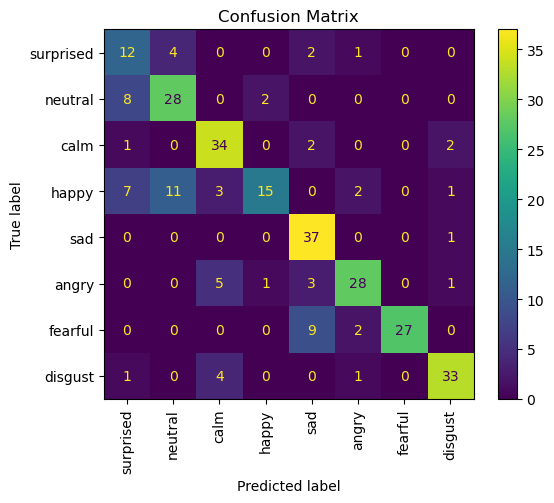

In [31]:
# -------------------- Confusion Matrix --------------------
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        preds = model(inputs).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS.values())
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

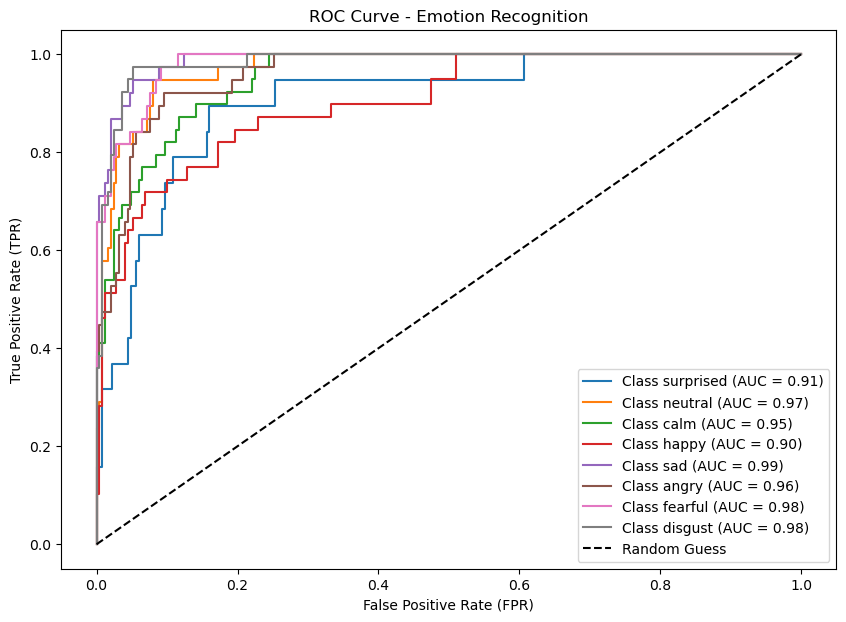

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to one-hot encoding (if not already)
num_classes = len(EMOTIONS)  # Assuming EMOTIONS is a dictionary mapping labels
all_probs, all_labels = [], []

# Get predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.cpu().numpy()
        preds = model(inputs).cpu().numpy()  # Get raw logits

        all_probs.extend(preds)  # Store predicted probabilities
        all_labels.extend(labels)  # Store actual labels

# Convert lists to NumPy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Convert labels to one-hot encoding
all_labels_one_hot = np.eye(num_classes)[all_labels]

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {EMOTIONS[i]} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Emotion Recognition")
plt.legend(loc="lower right")
plt.show()
